We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (71/71), 169.42 KiB | 4.98 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py", line 286, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py", line 1238, in hf_hub_download
    metadata = get_hf_file_metadata(
  File "/usr/local/lib/python3.10/dist-packages/huggingfa

We import the required packages and the lag llama estimator object which we can use to make predictions.

We download the [Melbourne Pedestrian Counts](https://zenodo.org/records/3898350) dataset used in our [paper](https://time-series-foundation-models.github.io/lag-llama.pdf). This is a dataset that the model has never seen before.

We then set the forecast length of the dataset for inference. Here we use the default prediction length of the dataset (48).

Note how the frequency of the dataset does not matter, since lag-llama can (train and) perform inference with any data of any frequency.

We create a model object with the hyperparameters from the pretrained model, and the prediction length.

In [3]:
!gdown https://drive.google.com/uc?id=18sra_8u1BZZWAzAabuMzzF_BNQmjprfl

/bin/bash: line 1: gdown: command not found


In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='66')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48)

In [12]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator
dataset = get_dataset("pedestrian_counts")

backtest_dataset = dataset.test
training_dataset = dataset.train
prediction_length = dataset.metadata.prediction_length
context_length = 32
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
batch_size = 32
num_batches_per_epoch = 50
checlpoint_path = "checkpoints/lag-llama.ckpt"
checlpoint_path = "/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=397-step=38152.ckpt"
ckpt = torch.load(checlpoint_path, map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    ckpt_path=checlpoint_path,
    prediction_length=prediction_length,
    context_length=context_length,
    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    trainer_kwargs={
        "max_epochs": 400,
    }
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

transformer.h.0.attn.kv_proj.lora_A Parameter containing:
tensor([[-0.0335, -0.1089, -0.0087,  ..., -0.0244,  0.0923,  0.0369],
        [-0.0631,  0.0098, -0.0765,  ..., -0.1381, -0.1101, -0.1092],
        [-0.0091,  0.0368, -0.0135,  ..., -0.0233, -0.0047,  0.0635],
        ...,
        [-0.0418, -0.0093,  0.0154,  ...,  0.0374, -0.0113,  0.0229],
        [-0.0127, -0.0390,  0.0393,  ..., -0.0541, -0.0242, -0.0024],
        [ 0.0334, -0.0102,  0.0132,  ..., -0.0516,  0.0289, -0.0025]],
       device='cuda:0', requires_grad=True)
transformer.h.0.attn.kv_proj.lora_B Parameter containing:
tensor([[ 0.0140,  0.0528,  0.0676,  0.0226],
        [-0.0101, -0.0069,  0.0707, -0.0273],
        [-0.0252,  0.0082, -0.0028, -0.0365],
        ...,
        [-0.0190,  0.0031,  0.0026,  0.0083],
        [ 0.0053, -0.0057, -0.0090,  0.0081],
        [-0.0116, -0.0019, -0.0004, -0.0070]], device='cuda:0',
       requires_grad=True)
transformer.h.0.attn.q_proj.lora_A Parameter containing:
tensor([[ 1.566

In [13]:
next(iter((dataset.train)))

{'target': array([53., 43., 10., ..., 37., 51., 21.], dtype=float32),
 'start': Period('2009-05-01 00:00', 'H'),
 'item_id': 0,
 'data_id': 0,
 'feat_static_cat': array([0], dtype=int32)}

In [2]:
from pytorch_lightning import Trainer
trainer = Trainer(max_epochs=500)
# trainer.fit(lightning_module, estimator.create_trainer_dl(dataset.train, lightning_module))
estimator.train(dataset.train, ckpt_path="/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_111/checkpoints/epoch=374-step=37002.ckpt")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Resto

transformer.h.0.attn.kv_proj.lora_A Parameter containing:
tensor([[ 0.0119, -0.0165,  0.0566,  ..., -0.0343, -0.0389, -0.0793],
        [ 0.0061,  0.0182, -0.0052,  ..., -0.0685,  0.0452, -0.0680],
        [-0.0671,  0.0619, -0.0733,  ...,  0.0787,  0.0463, -0.0522],
        ...,
        [ 0.0161, -0.0133, -0.0192,  ..., -0.0418,  0.0100, -0.0482],
        [-0.0540, -0.0573,  0.0532,  ...,  0.0408,  0.0211, -0.0038],
        [-0.0651,  0.0494, -0.0829,  ..., -0.0050, -0.0263, -0.0348]],
       device='cuda:0', requires_grad=True)
transformer.h.0.attn.kv_proj.lora_B Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0', requires_grad=True)
transformer.h.0.attn.q_proj.lora_A Parameter containing:
tensor([[-0.0151, -0.0661,  0.0516,  0.0153, -0.0661,  0.0768, -0.0320,  0.0730,
          0.0100, -0.0428,  0.0083, -0.0335,  0.0011,  0.0177

Epoch 375, global step 37052: 'train_loss' reached 5.47356 (best 5.47356), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=375-step=37052.ckpt' as top 1


Epoch 376: |          | 50/? [00:16<00:00,  3.02it/s, v_num=112]

Epoch 376, global step 37102: 'train_loss' reached 5.25170 (best 5.25170), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=376-step=37102.ckpt' as top 1


Epoch 377: |          | 50/? [00:15<00:00,  3.21it/s, v_num=112]

Epoch 377, global step 37152: 'train_loss' reached 5.24709 (best 5.24709), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=377-step=37152.ckpt' as top 1


Epoch 378: |          | 50/? [00:15<00:00,  3.19it/s, v_num=112]

Epoch 378, global step 37202: 'train_loss' was not in top 1


Epoch 379: |          | 50/? [00:15<00:00,  3.16it/s, v_num=112]

Epoch 379, global step 37252: 'train_loss' reached 5.20588 (best 5.20588), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=379-step=37252.ckpt' as top 1


Epoch 380: |          | 50/? [00:16<00:00,  3.08it/s, v_num=112]

Epoch 380, global step 37302: 'train_loss' reached 5.18096 (best 5.18096), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=380-step=37302.ckpt' as top 1


Epoch 381: |          | 50/? [00:16<00:00,  3.06it/s, v_num=112]

Epoch 381, global step 37352: 'train_loss' reached 5.14665 (best 5.14665), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=381-step=37352.ckpt' as top 1


Epoch 382: |          | 50/? [00:16<00:00,  3.11it/s, v_num=112]

Epoch 382, global step 37402: 'train_loss' was not in top 1


Epoch 383: |          | 50/? [00:16<00:00,  3.02it/s, v_num=112]

Epoch 383, global step 37452: 'train_loss' was not in top 1


Epoch 384: |          | 50/? [00:15<00:00,  3.17it/s, v_num=112]

Epoch 384, global step 37502: 'train_loss' reached 5.13702 (best 5.13702), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=384-step=37502.ckpt' as top 1


Epoch 385: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 385, global step 37552: 'train_loss' was not in top 1


Epoch 386: |          | 50/? [00:15<00:00,  3.14it/s, v_num=112]

Epoch 386, global step 37602: 'train_loss' was not in top 1


Epoch 387: |          | 50/? [00:16<00:00,  3.10it/s, v_num=112]

Epoch 387, global step 37652: 'train_loss' was not in top 1


Epoch 388: |          | 50/? [00:17<00:00,  2.94it/s, v_num=112]

Epoch 388, global step 37702: 'train_loss' was not in top 1


Epoch 389: |          | 50/? [00:15<00:00,  3.18it/s, v_num=112]

Epoch 389, global step 37752: 'train_loss' reached 5.11490 (best 5.11490), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=389-step=37752.ckpt' as top 1


Epoch 390: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 390, global step 37802: 'train_loss' was not in top 1


Epoch 391: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 391, global step 37852: 'train_loss' was not in top 1


Epoch 392: |          | 50/? [00:16<00:00,  3.03it/s, v_num=112]

Epoch 392, global step 37902: 'train_loss' was not in top 1


Epoch 393: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 393, global step 37952: 'train_loss' was not in top 1


Epoch 394: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 394, global step 38002: 'train_loss' reached 5.09281 (best 5.09281), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=394-step=38002.ckpt' as top 1


Epoch 395: |          | 50/? [00:15<00:00,  3.25it/s, v_num=112]

Epoch 395, global step 38052: 'train_loss' was not in top 1


Epoch 396: |          | 50/? [00:15<00:00,  3.19it/s, v_num=112]

Epoch 396, global step 38102: 'train_loss' was not in top 1


Epoch 397: |          | 50/? [00:16<00:00,  3.09it/s, v_num=112]

Epoch 397, global step 38152: 'train_loss' reached 5.08676 (best 5.08676), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_112/checkpoints/epoch=397-step=38152.ckpt' as top 1


Epoch 398: |          | 50/? [00:15<00:00,  3.17it/s, v_num=112]

Epoch 398, global step 38202: 'train_loss' was not in top 1


Epoch 399: |          | 50/? [00:15<00:00,  3.24it/s, v_num=112]

Epoch 399, global step 38252: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: |          | 50/? [00:15<00:00,  3.23it/s, v_num=112]


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['model.transformer.h.0.attn.q_proj.lora_A', 'model.transformer.h.0.attn.q_proj.lora_B', 'model.transformer.h.0.attn.kv_proj.lora_A', 'model.transformer.h.0.attn.kv_proj.lora_B', 'model.transformer.h.1.attn.q_proj.lora_A', 'model.transformer.h.1.attn.q_proj.lora_B', 'model.transformer.h.1.attn.kv_proj.lora_A', 'model.transformer.h.1.attn.kv_proj.lora_B', 'model.transformer.h.2.attn.q_proj.lora_A', 'model.transformer.h.2.attn.q_proj.lora_B', 'model.transformer.h.2.attn.kv_proj.lora_A', 'model.transformer.h.2.attn.kv_proj.lora_B', 'model.transformer.h.3.attn.q_proj.lora_A', 'model.transformer.h.3.attn.q_proj.lora_B', 'model.transformer.h.3.attn.kv_proj.lora_A', 'model.transformer.h.3.attn.kv_proj.lora_B', 'model.transformer.h.4.attn.q_proj.lora_A', 'model.transformer.h.4.attn.q_proj.lora_B', 'model.transformer.h.4.attn.k

In [2]:
estimator_args["time_feat"]

True

In [3]:
print(next(iter(dataset.train)), "\n" ,next(iter(dataset.test))) 

{'target': array([53., 43., 10., ..., 37., 51., 21.], dtype=float32), 'start': Period('2009-05-01 00:00', 'H'), 'item_id': 'T1', 'feat_static_cat': array([0], dtype=int32)} 
 {'target': array([53., 43., 10., ..., 25., 32., 27.], dtype=float32), 'start': Period('2009-05-01 00:00', 'H'), 'item_id': 'T1', 'feat_static_cat': array([0], dtype=int32)}


In [4]:
estimator_args["time_feat"]

True

In [3]:
predictor = estimator.create_predictor(transformation, lightning_module)

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
    num_samples=500,
)

window_length: 48


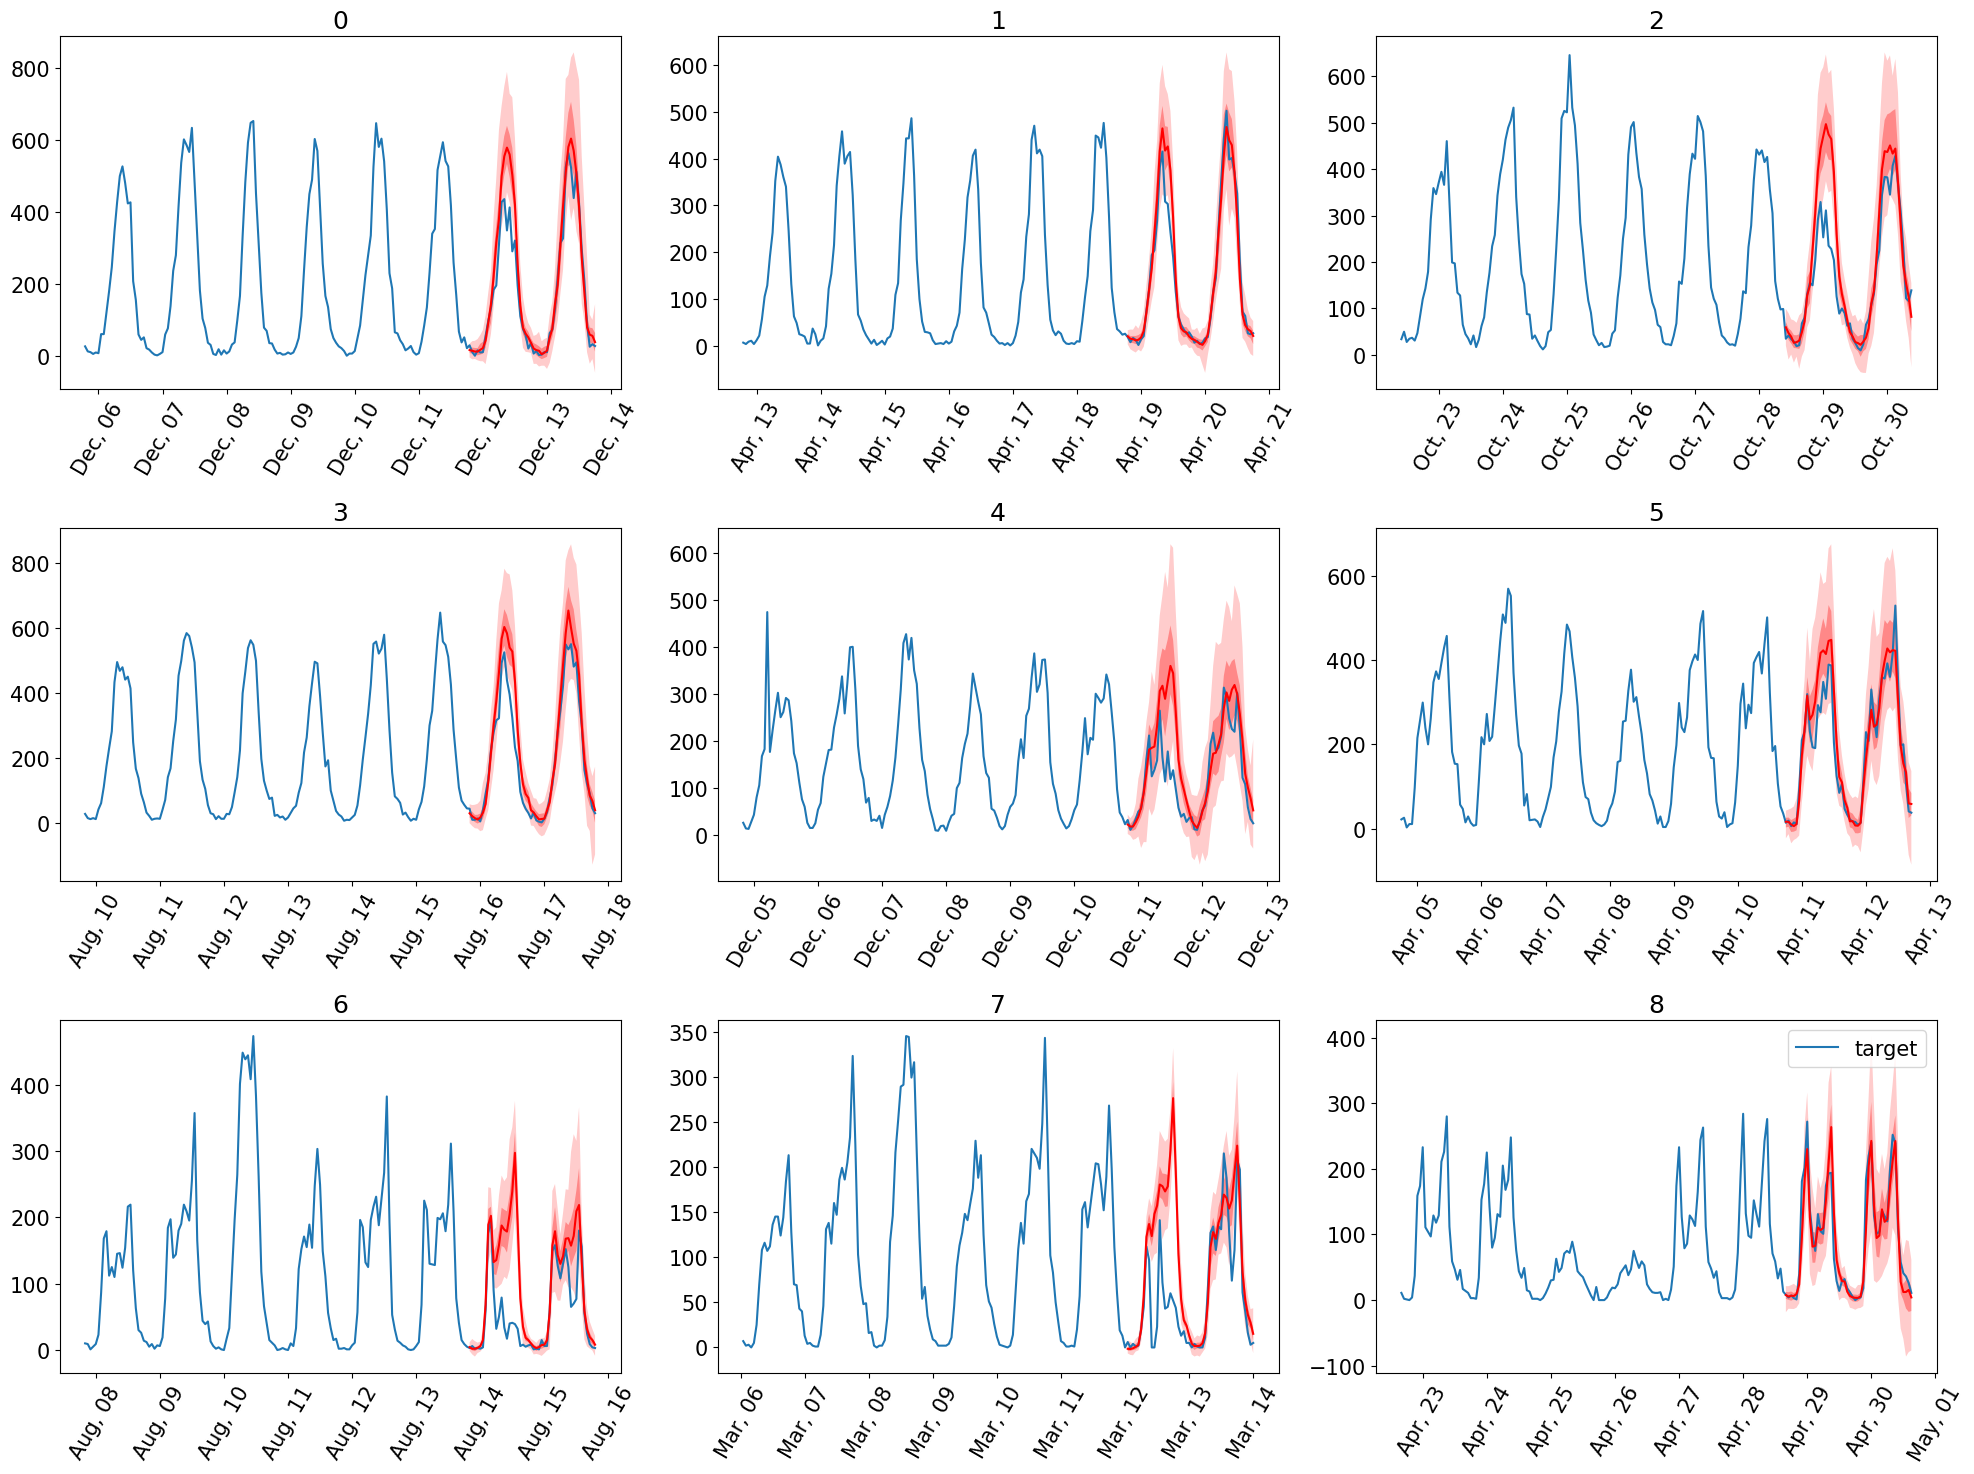

In [5]:
forecasts = list(forecast_it)
tss = list(ts_it)
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='r')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

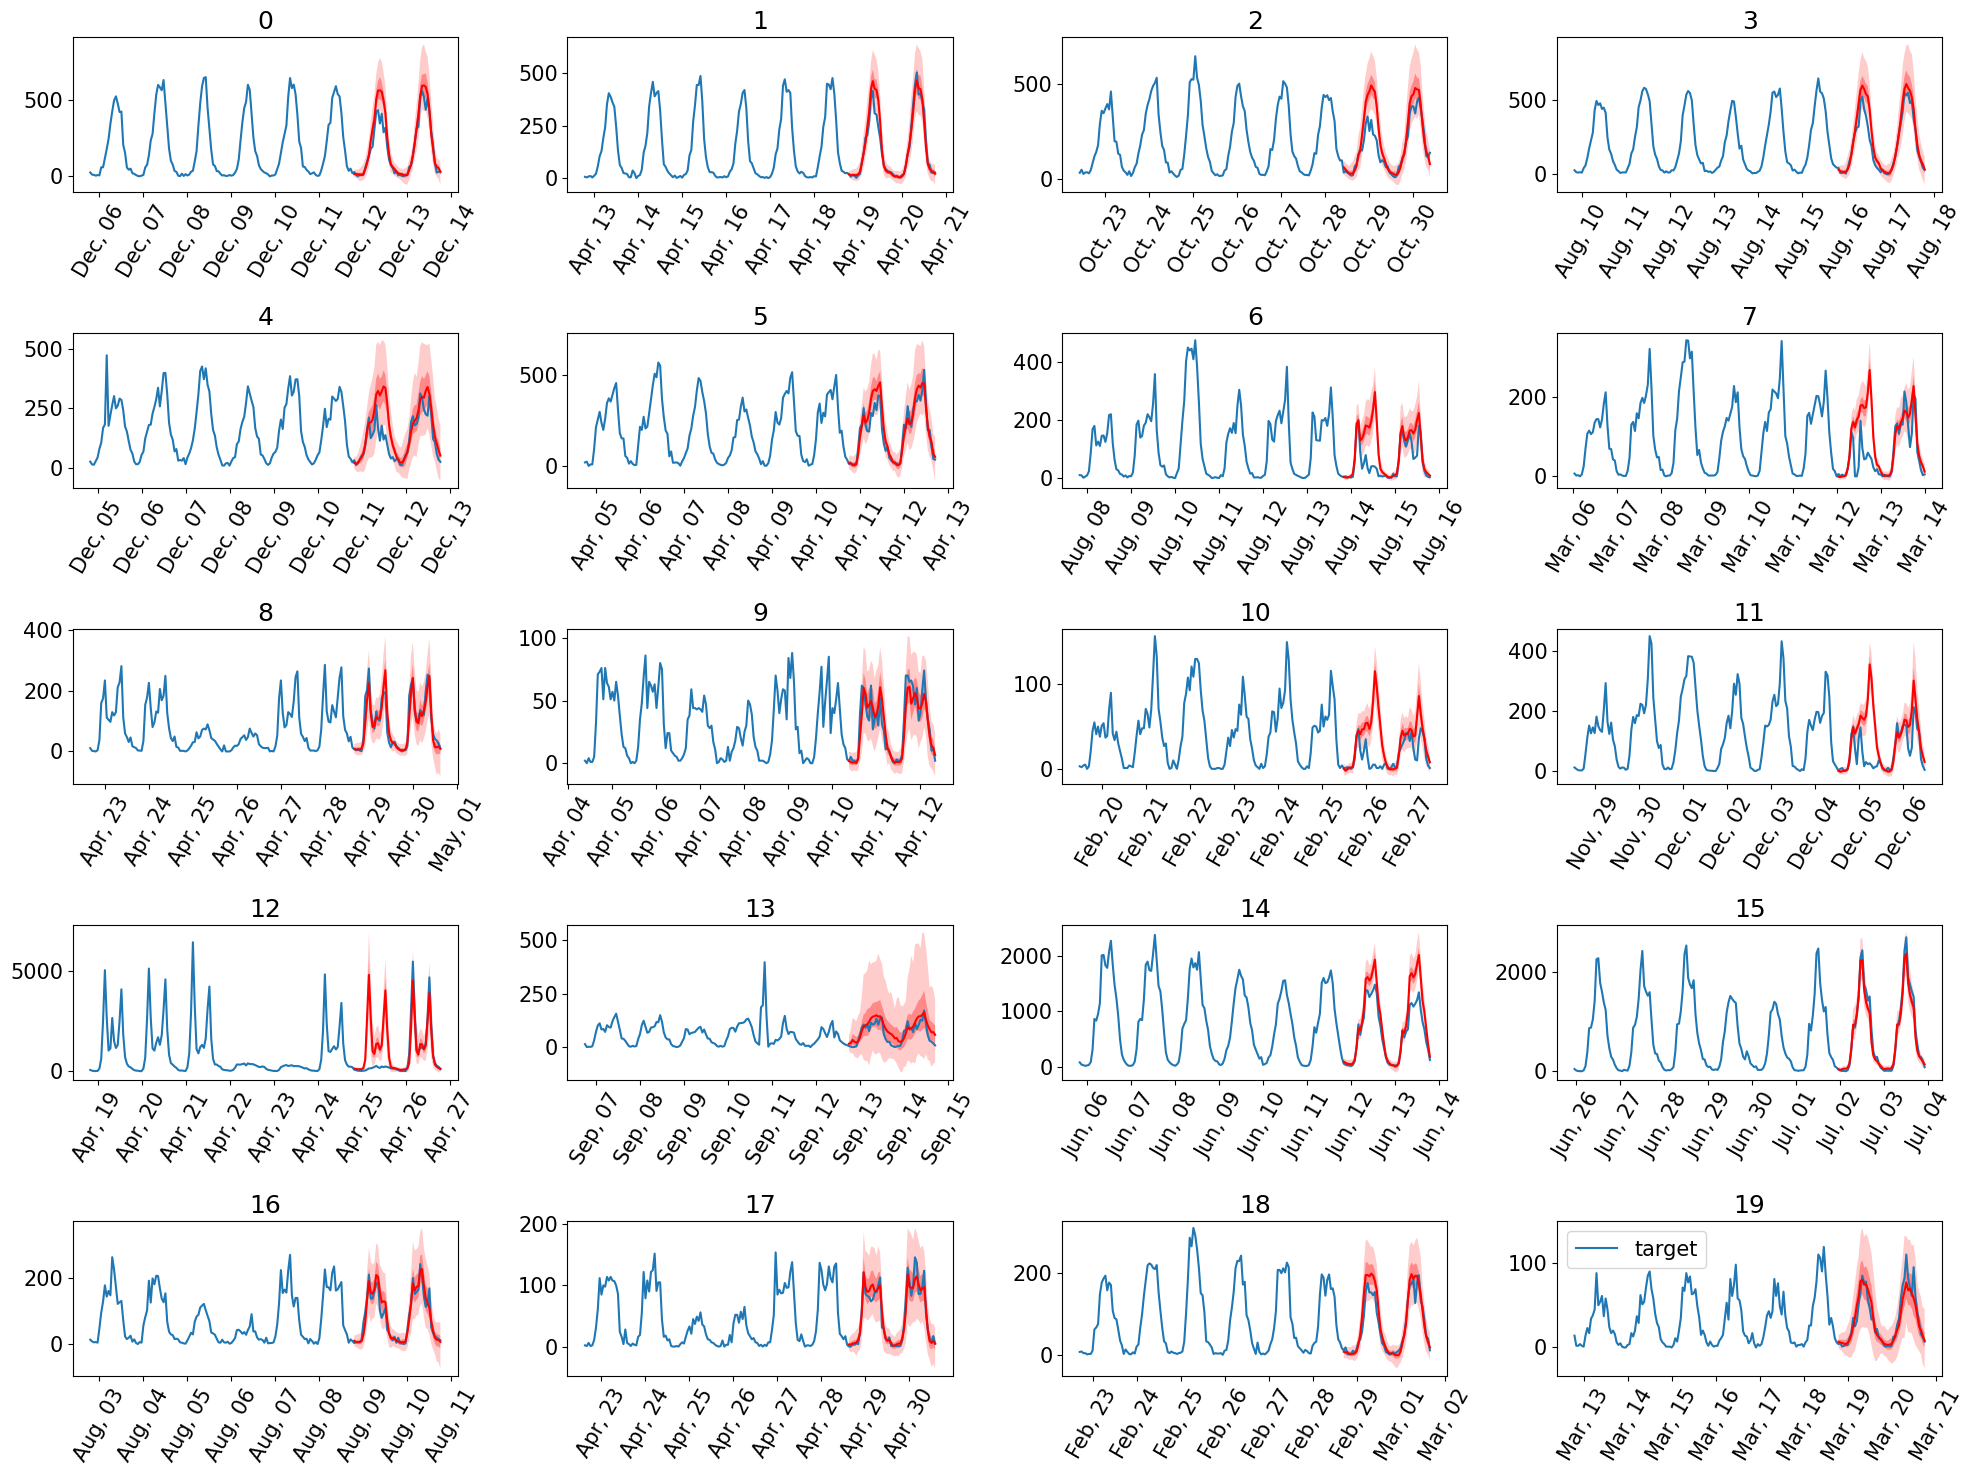

In [11]:
forecasts = list(forecast_it)
tss = list(ts_it)
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='r')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

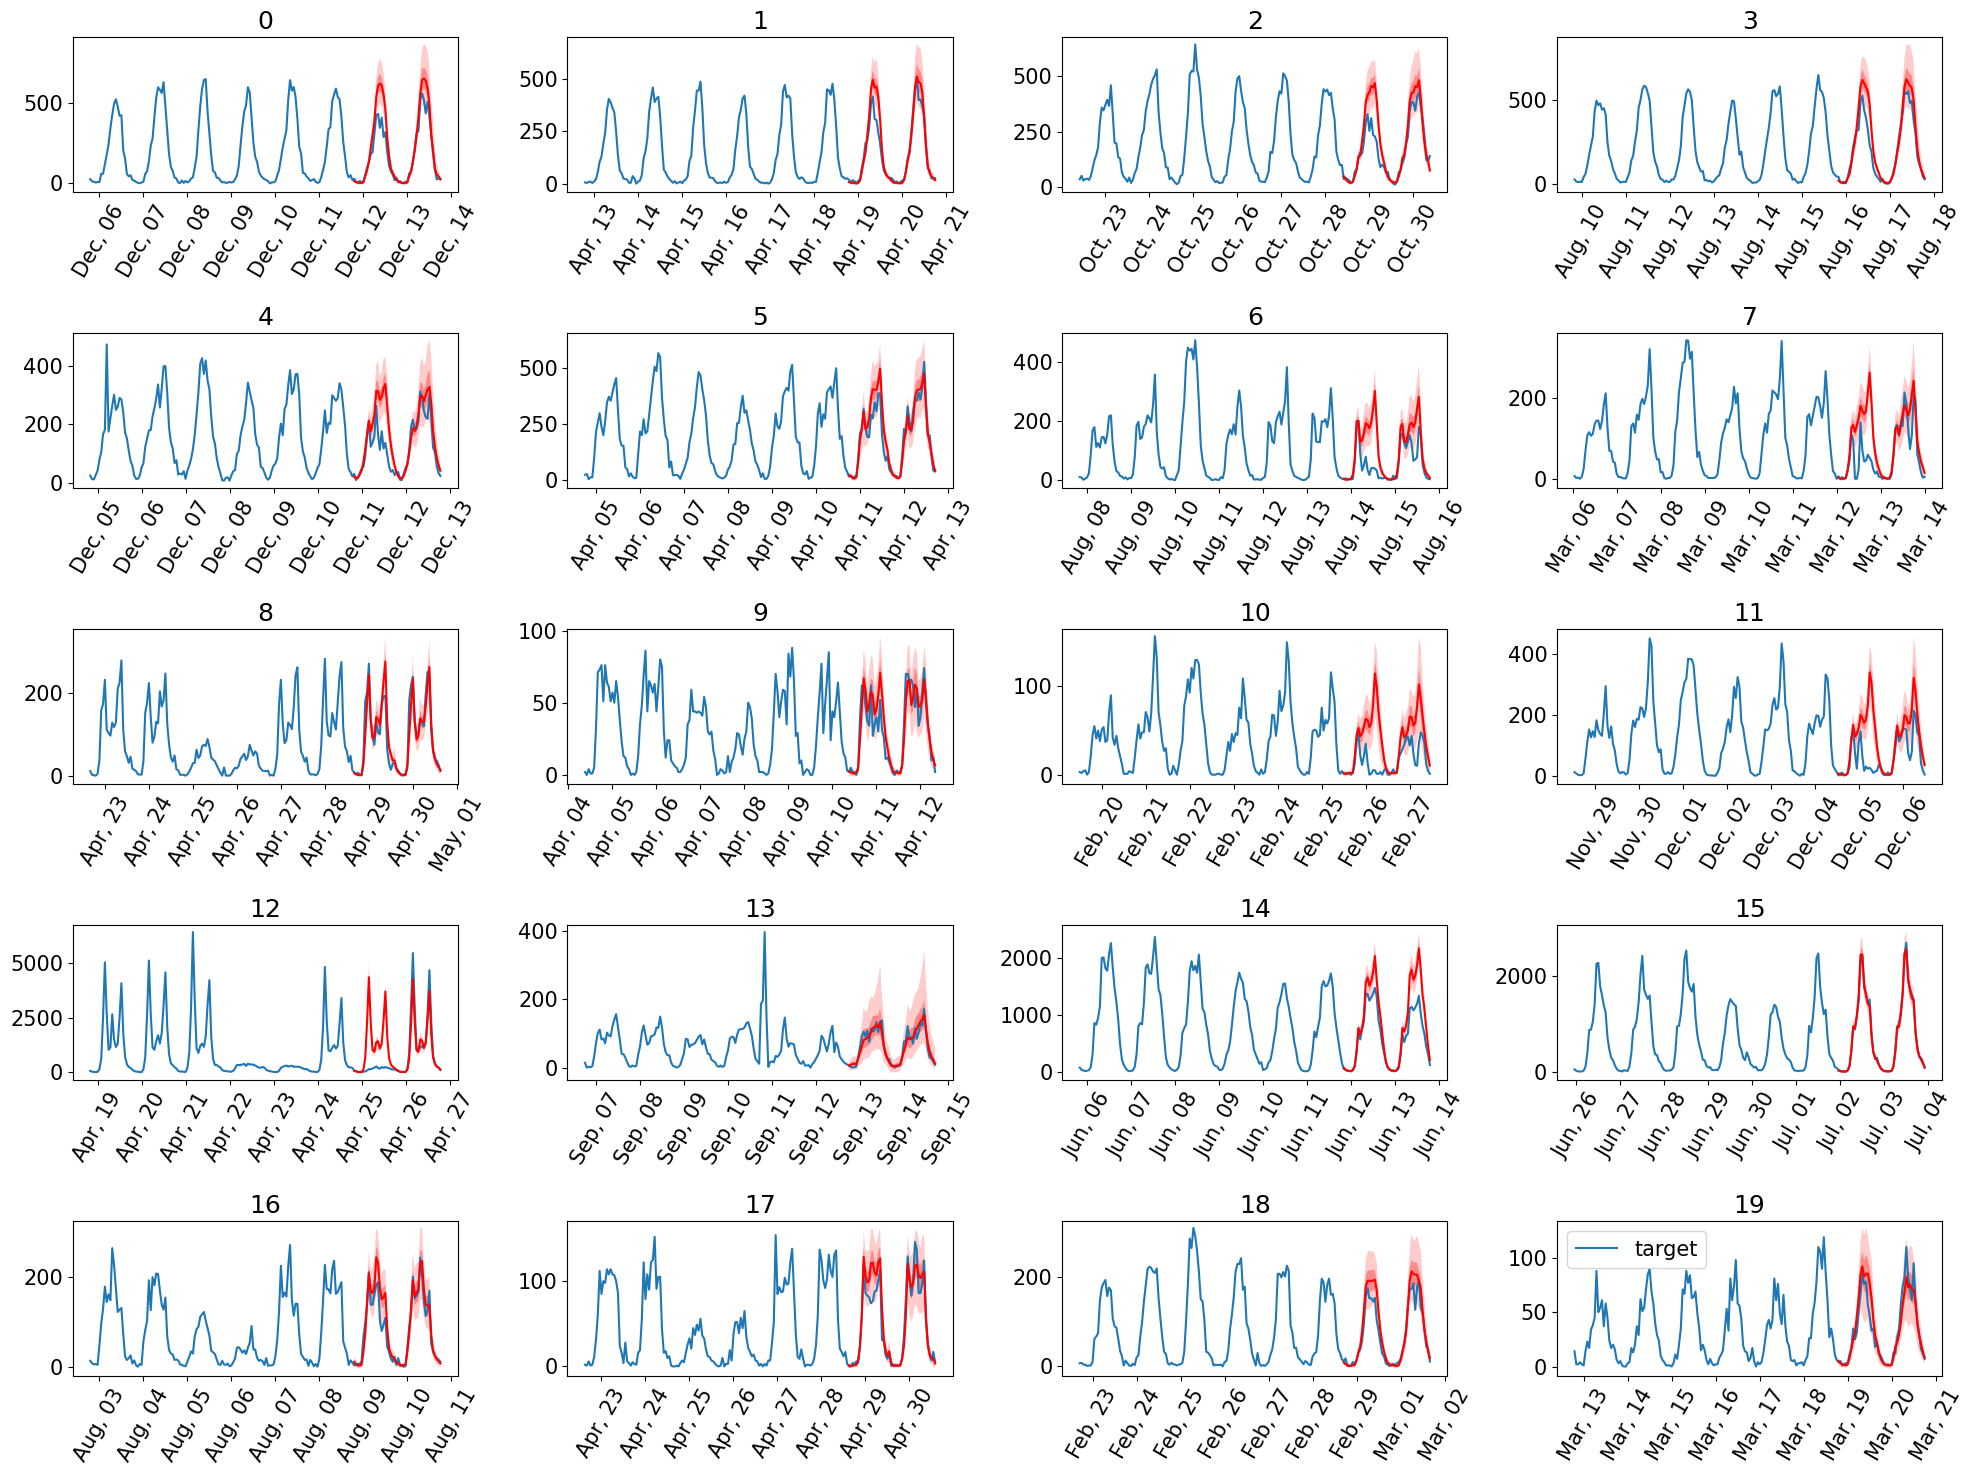

In [18]:
forecasts = list(forecast_it)
tss = list(ts_it)
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='r')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [16]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 66it [00:00, 2683.03it/s]


In [7]:
import json


print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 40346.49517406117,
    "abs_error": 177061.0224456787,
    "abs_target_sum": 583225.0,
    "abs_target_mean": 184.09880050505052,
    "seasonal_error": 157.4968212636783,
    "MASE": 0.3271918102284092,
    "MAPE": 0.9590918339216598,
    "sMAPE": 0.4743596119712098,
    "MSIS": 3.566169034661442,
    "QuantileLoss[0.1]": 127138.7290992737,
    "Coverage[0.1]": 0.14962121212121213,
    "QuantileLoss[0.5]": 177061.02138400078,
    "Coverage[0.5]": 0.6180555555555556,
    "QuantileLoss[0.9]": 79477.0935218334,
    "Coverage[0.9]": 0.9674873737373736,
    "RMSE": 200.8643700959958,
    "NRMSE": 1.0910683260561784,
    "ND": 0.30358956225415357,
    "wQuantileLoss[0.1]": 0.21799259136572283,
    "wQuantileLoss[0.5]": 0.3035895604337962,
    "wQuantileLoss[0.9]": 0.13627175364882063,
    "mean_absolute_QuantileLoss": 127892.28133503596,
    "mean_wQuantileLoss": 0.21928463514944654,
    "MAE_Coverage": 0.46748737373737365,
    "OWA": NaN
}


We perform inference on this dataset zero-shot!

In [17]:
import json


print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 40044.118158513855,
    "abs_error": 174652.06617736816,
    "abs_target_sum": 583225.0,
    "abs_target_mean": 184.09880050505052,
    "seasonal_error": 157.4968212636783,
    "MASE": 0.32185513330544196,
    "MAPE": 0.9445179436686648,
    "sMAPE": 0.4647868691068707,
    "MSIS": 3.559743342997385,
    "QuantileLoss[0.1]": 127280.25140290262,
    "Coverage[0.1]": 0.1464646464646465,
    "QuantileLoss[0.5]": 174652.06642842293,
    "Coverage[0.5]": 0.6111111111111112,
    "QuantileLoss[0.9]": 78272.64139761924,
    "Coverage[0.9]": 0.9696969696969696,
    "RMSE": 200.11026500035888,
    "NRMSE": 1.086972128288631,
    "ND": 0.29945915586157684,
    "wQuantileLoss[0.1]": 0.21823524609353614,
    "wQuantileLoss[0.5]": 0.2994591562920364,
    "wQuantileLoss[0.9]": 0.134206595049285,
    "mean_absolute_QuantileLoss": 126734.98640964828,
    "mean_wQuantileLoss": 0.21730033247828584,
    "MAE_Coverage": 0.46969696969696967,
    "OWA": NaN
}


In [6]:
import numpy as np
import pandas as pd

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [9]:
df = pd.read_hdf("metr-la.h5")

FileNotFoundError: File metr-la.h5 does not exist

In [22]:
ndf = df.reset_index(drop=True)

In [23]:
sensors = ndf.transpose().index.tolist()

In [21]:
periods = []
for _ in range(len(df.columns)):
    periods.append(pd.Period("01-03-2012", freq="5min"))

In [24]:
ndf = ndf.transpose()

In [26]:
custom_ds_metadata = {
    "prediction_length": 12,
    "freq": "1min",
    "start": periods,
}

In [27]:
def create_dataset():
    # create target: noise + pattern
    # noise
    # noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # # pattern - sinusoid with different phase
    # sin_minusPi_Pi = np.sin(
    #     np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period))
    # )
    # sin_Zero_2Pi = np.sin(
    #     np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period))
    # )

    # pattern = np.concatenate(
    #     (
    #         np.tile(sin_minusPi_Pi.reshape(1, -1), (int(np.ceil(num_series / 2)), 1)),
    #         np.tile(sin_Zero_2Pi.reshape(1, -1), (int(np.floor(num_series / 2)), 1)),
    #     ),
    #     axis=0,
    # )

    target = ndf.values

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.zeros_like(target)

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.zeros(target.shape[1])
    return target, feat_dynamic_real, feat_static_cat

In [29]:
data_out = create_dataset(
)

In [30]:
target, feat_dynamic_real, feat_static_cat = data_out

In [31]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target, custom_ds_metadata["start"], feat_dynamic_real, feat_static_cat
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [33]:
train_entry = next(iter(train_ds))
train_entry.keys()
import matplotlib.pyplot as plt

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

NameError: name 'test_ds' is not defined

In [7]:
backtest_dataset

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f5c5a930850>, iterable=JsonLinesFile(path=PosixPath('/home/seyed/.gluonts/datasets/pedestrian_counts/test/data.json.gz'), start=0, n=None))

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

window_length: 48


In [10]:
forecasts = list(forecast_it)
tss = list(ts_it)

forward () {'past_target': tensor([[  18.,   28.,  110.,  ...,   37.,   51.,   21.],
        [   9.,   22.,   71.,  ...,   31.,   24.,   26.],
        [  43.,   92.,  166.,  ...,  121.,   98.,   99.],
        ...,
        [  41.,   23.,   74.,  ...,   35.,   44.,   22.],
        [  20.,   20.,   35.,  ...,   34.,   27.,   19.],
        [  33.,   59.,  190.,  ..., 1522., 1414., 1544.]], device='cuda:0'), 'past_observed_values': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'), 'past_time_feat': tensor([[[-0.5000, -0.5000,  0.5000,  0.0000,  0.3000,  0.3137],
         [-0.5000, -0.5000, -0.5000,  0.1667,  0.3333,  0.3164],
         [-0.5000, -0.5000, -0.4565,  0.1667,  0.3333,  0.3164],
         ...,
         [-0.5000, -0.5000,  0.1957, -0.3333, -0.1667,  0.4425],
     

We obtain some metrics for our reference. The CRPS metric is a commonly used metric in time series forecasting literature. We obtain a CRPS of **0.2531** with this dataset (close to the number reported in Table 1 of the [paper](https://time-series-foundation-models.github.io/lag-llama.pdf)).

In [37]:
evaluator = Evaluator()

In [38]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 207it [00:00, 6308.55it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [39]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.08729592451058753


We plot the forecasts of our model on this dataset.

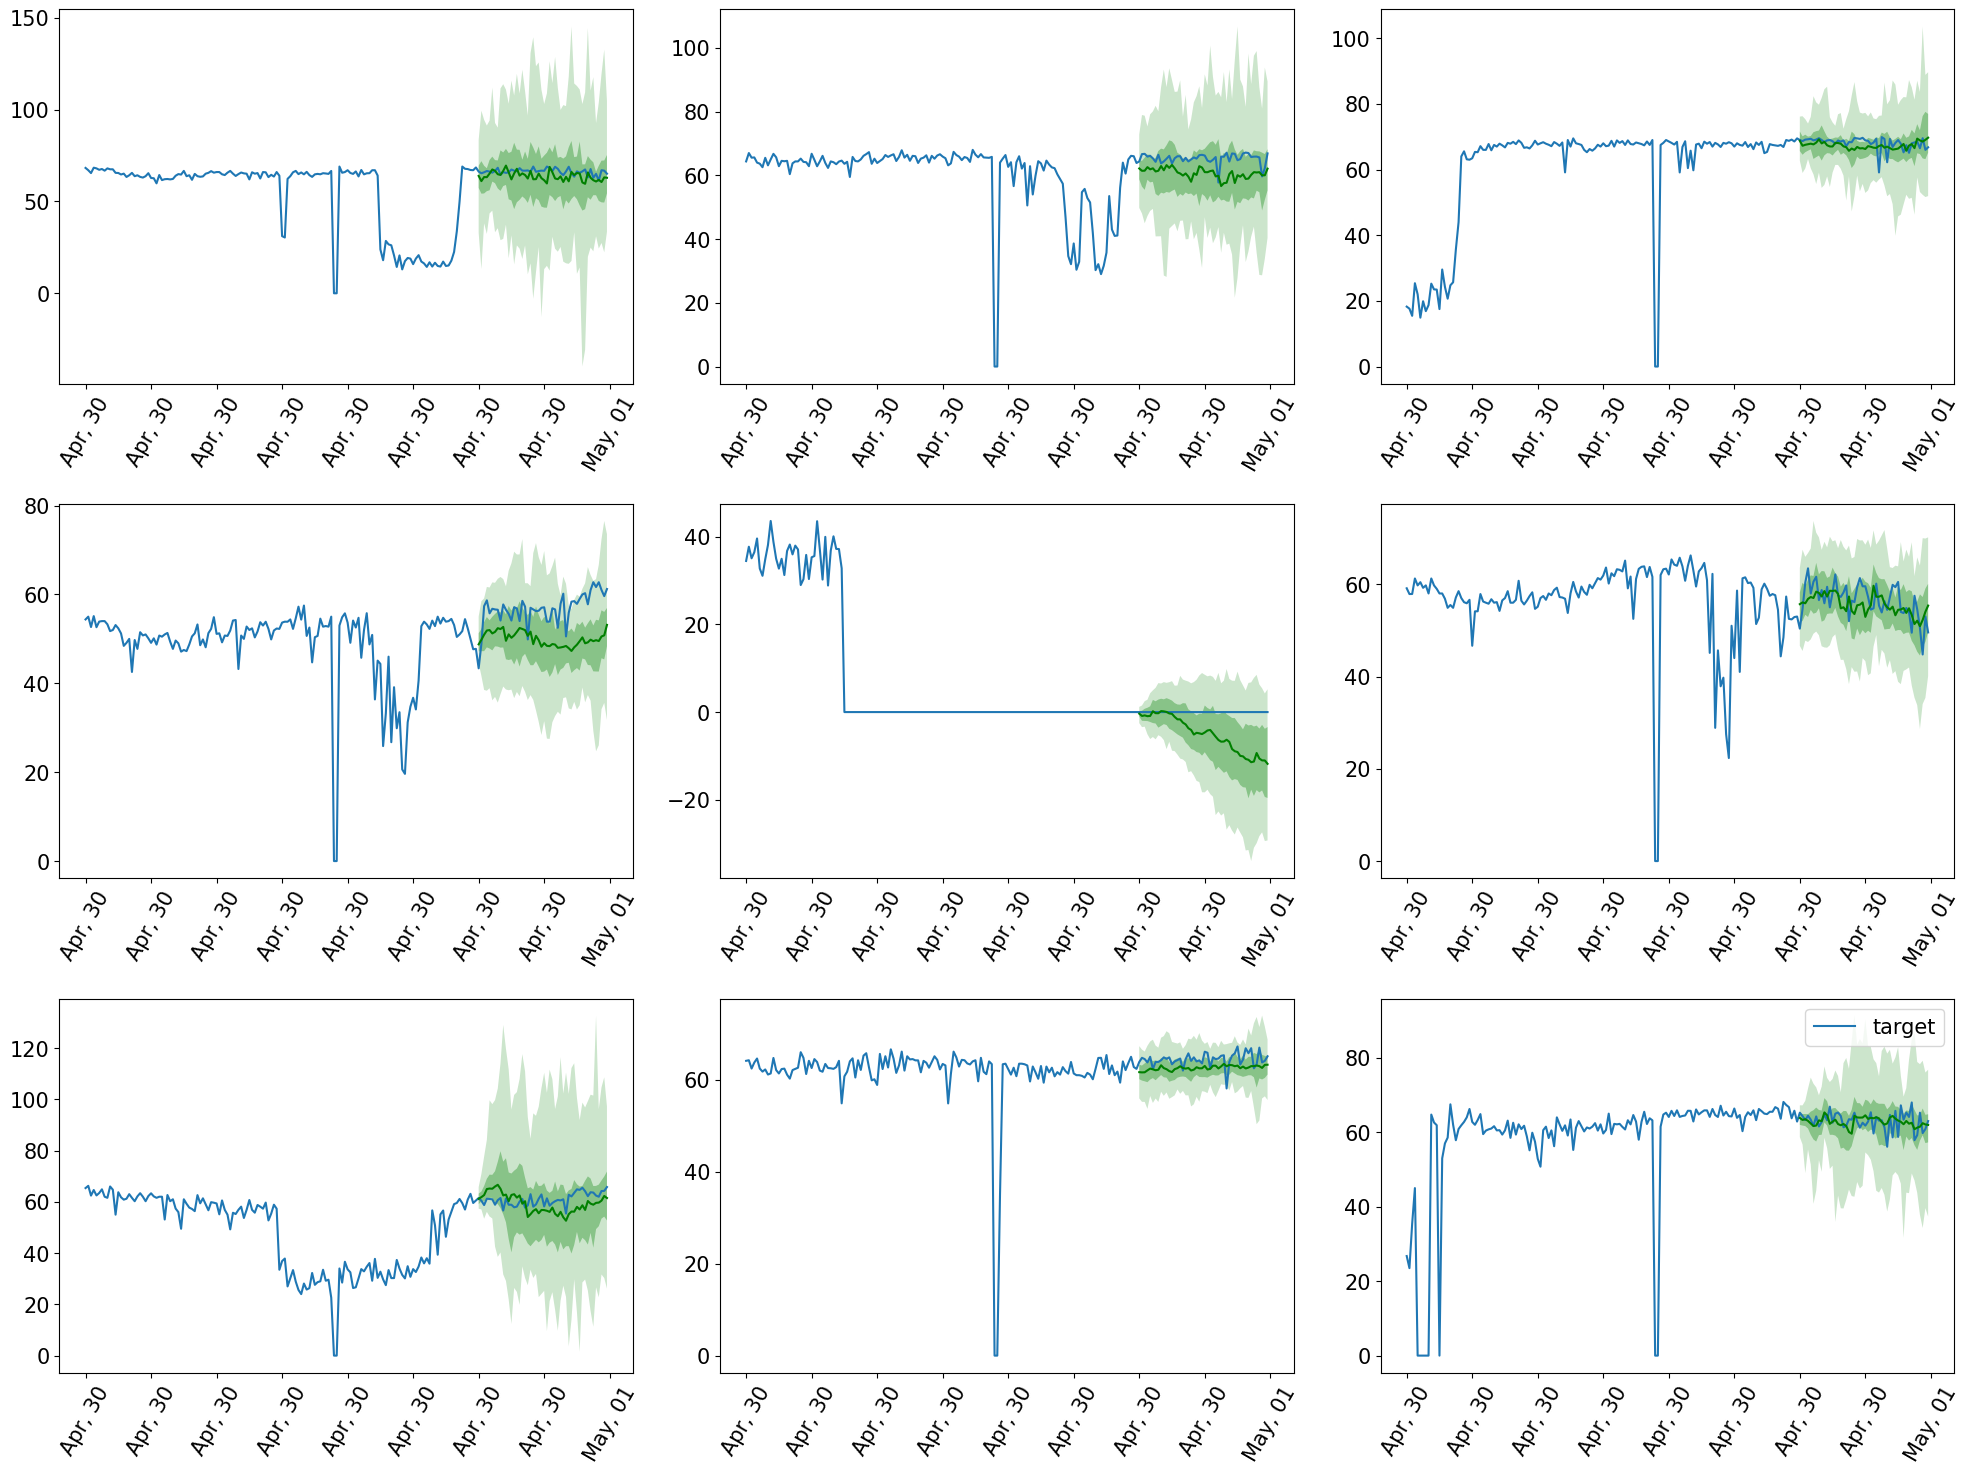

In [40]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Coming Soon:

⭐ An <b>online gradio demo</b> where you can upload time series and get zero-shot predictions.

⭐ Features for <b>finetuning</b> the foundation model

⭐ Features for <b>pretraining</b> Lag-Llama on your own large-scale data

⭐ Scripts to <b>reproduce</b> all results in the paper.


____

Stay Tuned!🦙